In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from matplotlib.patches import Patch

In [113]:
file = "data/output_with_sentiment.csv"
df = pd.read_csv(file)

In [114]:
df = df[["index",
    "text",
    "kontext",
    "klassifikation.tore_bayern",
    "klassifikation.tore_gegner",
    "klassifikation.phase",
    "meta.saison",
    "meta.spieltag",
    "meta.heim_auswaerts",
    "meta.gegner",
    "meta.tabelle",
    "meta.ballbesitz_bayern",
    "ergebnis.bayern",
    "ergebnis.gegner",
    "offizielle.schiedsrichter",
    "offizielle.kommentator",
    "source_file",
    "sentiment__fine_tuned_german_sentiment",
    "sentiment__fine_tuned_german_sentiment__conf"
]]

In [115]:
mapping = {'Positiv': 1, 'Negativ': -1, 'Neutral': 0}
df['sentiment_numeric'] = df['sentiment__fine_tuned_german_sentiment'].map(mapping)

In [116]:
df['weighted_sentiment'] = (
    df['sentiment_numeric'] * df['sentiment__fine_tuned_german_sentiment__conf']
)

In [117]:
df[df["kontext"] == "Neutral"]

,index,text,kontext,klassifikation.tore_bayern,klassifikation.tore_gegner,klassifikation.phase,meta.saison,meta.spieltag,meta.heim_auswaerts,meta.gegner,...,meta.ballbesitz_bayern,ergebnis.bayern,ergebnis.gegner,offizielle.schiedsrichter,offizielle.kommentator,source_file,sentiment__fine_tuned_german_sentiment,sentiment__fine_tuned_german_sentiment__conf,sentiment_numeric,weighted_sentiment
0,0,Das erste Duell der Großkopferten seit dem Mei...,Neutral,0,0,0,23/24,10,Auswärts,Borussia Dortmund,...,0.51,4,0,Deniz Aytekin,Oliver Schmidt,23-24_S10_borussia_dortmund.json,Neutral,0.8800,0,0.0000
8,8,Schauen wir auf das Pärchen Schlotterbeck und ...,Neutral,1,0,1,23/24,10,Auswärts,Borussia Dortmund,...,0.51,4,0,Deniz Aytekin,Oliver Schmidt,23-24_S10_borussia_dortmund.json,Negativ,0.8217,-1,-0.8217
13,13,"Vierter Treffer nach Ecke, achter nach Standar...",Neutral,1,0,1,23/24,10,Auswärts,Borussia Dortmund,...,0.51,4,0,Deniz Aytekin,Oliver Schmidt,23-24_S10_borussia_dortmund.json,Negativ,0.9161,-1,-0.9161
14,14,"Schon das siebte Gegentor nach ruhendem Ball, ...",Neutral,1,0,1,23/24,10,Auswärts,Borussia Dortmund,...,0.51,4,0,Deniz Aytekin,Oliver Schmidt,23-24_S10_borussia_dortmund.json,Neutral,0.9738,0,0.0000
22,22,"Schlotterbeck ungestüm, Ryerson im Gegenpressi...",Neutral,1,0,1,23/24,10,Auswärts,Borussia Dortmund,...,0.51,4,0,Deniz Aytekin,Oliver Schmidt,23-24_S10_borussia_dortmund.json,Neutral,0.9826,0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7395,88,"Rönnow pariert prima, der Ball kommt postwende...",Neutral,3,0,2,24/25,9,Heim,1. FC Union Berlin,...,0.77,3,0,Dr. Matthias Jöllenbeck,Hansi Küpper,24-25_S9_1._fc_union_berlin.json,Neutral,0.8977,0,0.0000
7400,93,Ausnahme: das 1:4 in Barcelona in der Champion...,Neutral,3,0,2,24/25,9,Heim,1. FC Union Berlin,...,0.77,3,0,Dr. Matthias Jöllenbeck,Hansi Küpper,24-25_S9_1._fc_union_berlin.json,Neutral,0.9215,0,0.0000
7401,94,Rein in die letzte Minute dieser Partie.,Neutral,3,0,2,24/25,9,Heim,1. FC Union Berlin,...,0.77,3,0,Dr. Matthias Jöllenbeck,Hansi Küpper,24-25_S9_1._fc_union_berlin.json,Neutral,0.9755,0,0.0000
7403,96,"Sané hat noch mal die Chance, und Rönnow kann ...",Neutral,3,0,2,24/25,9,Heim,1. FC Union Berlin,...,0.77,3,0,Dr. Matthias Jöllenbeck,Hansi Küpper,24-25_S9_1._fc_union_berlin.json,Neutral,0.9835,0,0.0000


In [ ]:
# 1️⃣ Kontext sauber mappen (dreistufig)
def map_kontext(x):
    x = str(x).strip()
    if x == 'FC Bayern München':
        return 'FC Bayern München'
    elif x.lower() == 'neutral':
        return 'Neutral'
    else:
        return 'Gegner'

df['kontext_group'] = df['kontext'].apply(map_kontext)

# Kategorien fixieren (damit Pivot-Spalten immer existieren)
df['kontext_group'] = pd.Categorical(
    df['kontext_group'],
    categories=['FC Bayern München', 'Gegner', 'Neutral']
)

# 2️⃣ Durchschnittliches Sentiment pro Spiel & Kontext
sentiment_spieltag = (
    df.groupby(['source_file', 'kontext_group'], as_index=False)
      .agg({'weighted_sentiment': 'mean'})
)

# 3️⃣ Pivot -> Bayern / Gegner / Neutral nebeneinander
sentiment_spieltag_pivot = (
    sentiment_spieltag
    .pivot(index='source_file', columns='kontext_group', values='weighted_sentiment')
    .reset_index()
    .rename(columns={
        'FC Bayern München': 'sentiment.bayern',
        'Gegner': 'sentiment.gegner',
        'Neutral': 'sentiment.neutral'
    })
)
sentiment_spieltag_pivot.columns.name = None

# 4️⃣ Basisdaten (Spieltag, Gegner, Ergebnis, Saison) hinzufügen
df_spieltag = (
    df.groupby(['source_file'], as_index=False)
      .agg({
          'meta.gegner': 'first',
          'meta.spieltag': 'first',
          'meta.saison': 'first',
          'ergebnis.bayern': 'first',
          'ergebnis.gegner': 'first'
      })
)

# 5️⃣ Mergen
df_spieltag = df_spieltag.merge(sentiment_spieltag_pivot, on='source_file', how='left')

# 6️⃣ Sortieren (Saison & Spieltag)
df_spieltag = df_spieltag.sort_values(['meta.saison', 'meta.spieltag']).reset_index(drop=True)

df_spieltag

/var/folders/6l/0tgzd1nn0ms4kdqy51q3skzc0000gn/T/ipykernel_92265/948724590.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['source_file', 'kontext_group'], as_index=False)


,source_file,meta.gegner,meta.spieltag,meta.saison,ergebnis.bayern,ergebnis.gegner,sentiment.bayern,sentiment.gegner,sentiment.neutral
0,23-24_S1_sv_werder_bremen.json,SV Werder Bremen,1,23/24,4,0,0.609990,0.497444,0.000000
1,23-24_S2_fc_augsburg.json,FC Augsburg,2,23/24,3,1,0.346224,0.437377,-0.053576
2,23-24_S3_borussia_mönchengladbach.json,Borussia Mönchengladbach,3,23/24,2,1,0.611895,0.717675,-0.051435
3,23-24_S4_bayer_04_leverkusen.json,Bayer 04 Leverkusen,4,23/24,2,2,0.308459,0.579683,-0.026655
4,23-24_S5_vfl_bochum.json,VfL Bochum,5,23/24,7,0,0.588687,-0.161215,-0.072364
...,...,...,...,...,...,...,...,...,...
63,24-25_S30_1._fc_heidenheim.json,1. FC Heidenheim,30,24/25,4,0,0.673076,0.299852,-0.101313
64,24-25_S31_1._fsv_mainz_05.json,1. FSV Mainz 05,31,24/25,3,0,0.548393,0.361355,0.000000
65,24-25_S32_rb_leipzig.json,RB Leipzig,32,24/25,3,3,0.423793,0.604348,-0.051563
66,24-25_S33_borussia_mönchengladbach.json,Borussia Mönchengladbach,33,24/25,2,0,0.736997,0.641239,-0.003103


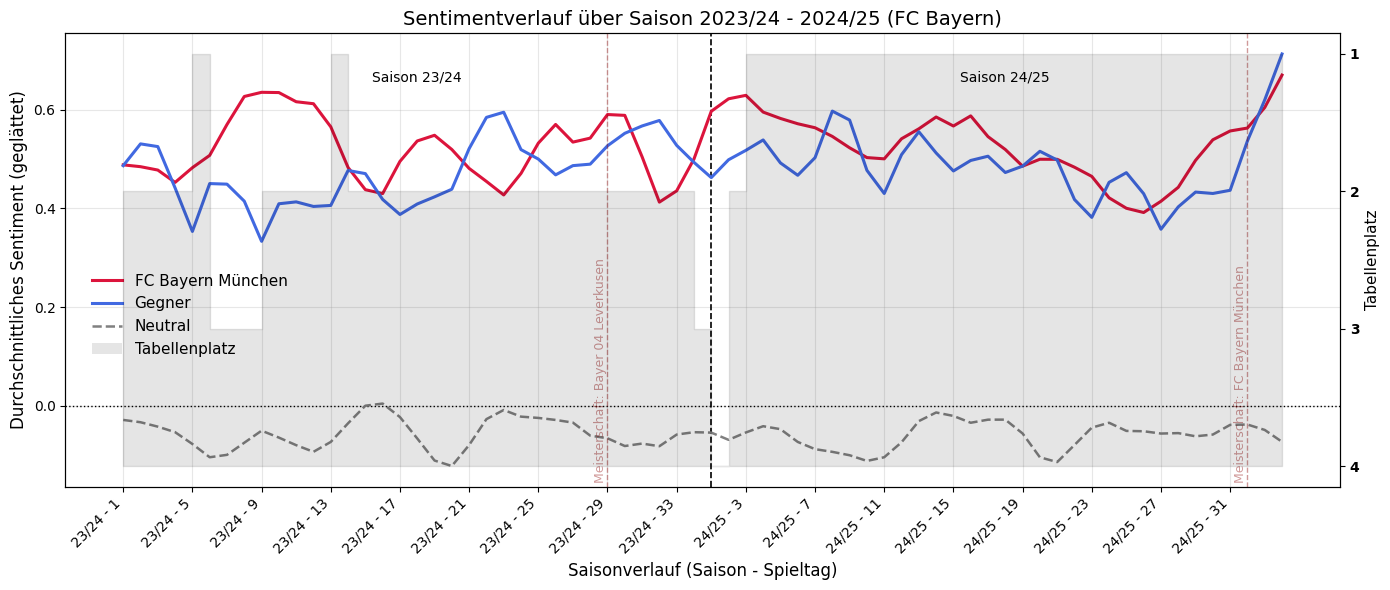

In [ ]:
# =========================
# 1) Basis: df_spieltag vorbereiten
# =========================
if 'meta.tabelle' in df.columns and 'meta.tabelle' not in df_spieltag.columns:
    tab = (
        df.groupby('source_file', as_index=False)['meta.tabelle']
          .first()
    )
    df_spieltag = df_spieltag.merge(tab, on='source_file', how='left')
    df_spieltag['meta.tabelle'] = pd.to_numeric(df_spieltag['meta.tabelle'], errors='coerce')

# =========================
# 2) Sortieren & X-Achse
# =========================
df_spieltag = df_spieltag.sort_values(["meta.saison", "meta.spieltag"]).reset_index(drop=True)
df_spieltag['saison_spieltag'] = (
    df_spieltag['meta.saison'].astype(str)
    + ' - '
    + df_spieltag['meta.spieltag'].astype(str)
)

# =========================
# 3) Glättung (Sentiment)
# =========================
window = 3
df_spieltag['sentiment.bayern.smooth'] = (
    df_spieltag['sentiment.bayern']
    .rolling(window, center=True, min_periods=1)
    .mean()
)
df_spieltag['sentiment.gegner.smooth'] = (
    df_spieltag['sentiment.gegner']
    .rolling(window, center=True, min_periods=1)
    .mean()
)
if 'sentiment.neutral' in df_spieltag.columns:
    df_spieltag['sentiment.neutral.smooth'] = (
        df_spieltag['sentiment.neutral']
        .rolling(window, center=True, min_periods=1)
        .mean()
    )

try:
    if len(df_spieltag) >= 5:
        df_spieltag['sentiment.bayern.smooth']  = savgol_filter(
            df_spieltag['sentiment.bayern.smooth'], 5, 2, mode='interp'
        )
        df_spieltag['sentiment.gegner.smooth']  = savgol_filter(
            df_spieltag['sentiment.gegner.smooth'], 5, 2, mode='interp'
        )
        if 'sentiment.neutral.smooth' in df_spieltag.columns:
            df_spieltag['sentiment.neutral.smooth'] = savgol_filter(
                df_spieltag['sentiment.neutral.smooth'], 5, 2, mode='interp'
            )
except Exception:
    pass

# =========================
# 4) Plot
# =========================
fig, ax1 = plt.subplots(figsize=(14, 6))

# 🔴 FC Bayern
ax1.plot(
    df_spieltag['saison_spieltag'],
    df_spieltag['sentiment.bayern.smooth'],
    label='FC Bayern München',
    color='crimson',
    linewidth=2.2,
    zorder=3
)

# 🔵 Gegner
ax1.plot(
    df_spieltag['saison_spieltag'],
    df_spieltag['sentiment.gegner.smooth'],
    label='Gegner',
    color='royalblue',
    linewidth=2.2,
    zorder=3
)

# ⚫ Neutral
if 'sentiment.neutral.smooth' in df_spieltag.columns:
    ax1.plot(
        df_spieltag['saison_spieltag'],
        df_spieltag['sentiment.neutral.smooth'],
        label='Neutral',
        color='gray',
        linestyle='--',
        linewidth=1.8,
        zorder=3
    )

# Null-Linie
ax1.axhline(0, color='black', linestyle=':', linewidth=1, zorder=2)

# 🟩 Saisonwechsel-Linien & Labels
season_change_indices = df_spieltag.index[
    df_spieltag['meta.saison'].shift() != df_spieltag['meta.saison']
].tolist()

for idx_pos, i in enumerate(season_change_indices[1:], start=1):
    ax1.axvline(i, color='black', linestyle='--', linewidth=1.2, zorder=2)
    prev = season_change_indices[idx_pos - 1]
    mid = (prev + i) / 2
    saison_name = df_spieltag.loc[i - 1, 'meta.saison']
    ax1.text(
        mid,
        ax1.get_ylim()[1] * 0.9,
        f"Saison {saison_name}",
        ha='center',
        va='top',
        fontsize=10,
        color='black'
    )

# letztes Saisonlabel
if len(season_change_indices) > 0:
    last_start = season_change_indices[-1]
    mid = (last_start + len(df_spieltag)) / 2
    saison_name = df_spieltag.loc[last_start, 'meta.saison']
    ax1.text(
        mid,
        ax1.get_ylim()[1] * 0.9,
        f"Saison {saison_name}",
        ha='center',
        va='top',
        fontsize=10,
        color='black'
    )

# 🧭 Achsenformatierung
step = max(1, len(df_spieltag) // 15)
ax1.set_xticks(np.arange(0, len(df_spieltag), step))
ax1.set_xticklabels(
    df_spieltag['saison_spieltag'].iloc[::step],
    rotation=45,
    ha='right'
)

ax1.set_xlabel("Saisonverlauf (Saison - Spieltag)", fontsize=12)
ax1.set_ylabel("Durchschnittliches Sentiment (geglättet)", fontsize=12)
ax1.set_title("Sentimentverlauf über Saison 2023/24 - 2024/25 (FC Bayern)", fontsize=14)

# =========================
# 5) Tabellenplatz – vollflächig im Hintergrund
# =========================
leg_handles, leg_labels = ax1.get_legend_handles_labels()

if 'meta.tabelle' in df_spieltag.columns and df_spieltag['meta.tabelle'].notna().any():
    ax2 = ax1.twinx()
    df_spieltag['meta.tabelle.int'] = df_spieltag['meta.tabelle'].round().astype('Int64')
    y_min = df_spieltag['meta.tabelle.int'].max()

    ax2.fill_between(
        df_spieltag['saison_spieltag'],
        df_spieltag['meta.tabelle.int'],
        y_min,
        color='black',
        alpha=0.1,
        step='post',
        zorder=0
    )

    # Legendeneintrag für Tabellenplatz hinzufügen
    tabellenplatz_patch = Patch(facecolor='black', alpha=0.1, label='Tabellenplatz')
    leg_handles.append(tabellenplatz_patch)
    leg_labels.append('Tabellenplatz')

    ymin, ymax = int(df_spieltag['meta.tabelle.int'].min()), int(df_spieltag['meta.tabelle.int'].max())
    ax2.set_yticks(np.arange(ymin, ymax + 1, 1))
    ax2.set_yticklabels([str(i) for i in range(ymin, ymax + 1)])
    ax2.invert_yaxis()
    ax2.set_ylabel("Tabellenplatz", color='black', fontsize=11)
    ax2.tick_params(axis='y', labelcolor='black')
    for label in ax2.get_yticklabels():
        label.set_fontweight("bold")

# =========================
# 6) Markierungen spezieller Spieltage
# =========================
markierungen = [
    ("23/24", 29, "Meisterschaft: Bayer 04 Leverkusen"),
    ("24/25", 32, "Meisterschaft: FC Bayern München"),
]

for saison, spieltag, label in markierungen:
    mask = (
        (df_spieltag['meta.saison'] == saison)
        & (df_spieltag['meta.spieltag'] == spieltag)
    )
    if mask.any():
        idx = df_spieltag.index[mask][0]
        ax1.axvline(
            idx,
            color='darkred',
            linestyle='--',
            linewidth=1,
            alpha=0.4,
            zorder=4
        )
        ax1.text(
            idx,
            ax1.get_ylim()[0] * 0.95,
            label,
            rotation=90,
            ha='right',
            va='bottom',
            fontsize=9,
            color='darkred',
            alpha=0.4
        )

# 🧾 Legende links mittig (mit Tabellenplatz)
ax1.legend(
    leg_handles,
    leg_labels,
    frameon=False,
    fontsize=11,
    loc='upper left',
    bbox_to_anchor=(0.01, 0.5)
)

# Raster & Layout
ax1.grid(alpha=0.3)
plt.tight_layout()

file_prefix = "data/results"
filename = "saisonverlauf"
plt.savefig(f'{file_prefix}/grafiken_png/{filename}.png')
plt.savefig(f'{file_prefix}/grafiken_pdf/{filename}.pdf')

plt.show()

In [120]:
# 1) Kontext dreistufig mappen: Bayern / Neutral / Gegner
def map_kontext(x):
    x = str(x).strip()
    if x == 'FC Bayern München':
        return 'FC Bayern München'
    elif x.lower() == 'neutral':
        return 'Neutral'
    else:
        return 'Gegner'

df['kontext_group'] = df['kontext'].apply(map_kontext)

# 2) Mean Sentiment pro Spiel & Kontext
sentiment_stats = (
    df.groupby(['source_file', 'kontext_group'], as_index=False)
      .agg({
          'meta.gegner': 'first',
          'ergebnis.bayern': 'first',
          'ergebnis.gegner': 'first',
          'weighted_sentiment': 'mean'
      })
)

# 3) Pivot: Bayern / Gegner / Neutral nebeneinander
sentiment_pivot = (
    sentiment_stats.pivot(
        index=['source_file', 'meta.gegner', 'ergebnis.bayern', 'ergebnis.gegner'],
        columns='kontext_group',
        values='weighted_sentiment'
    )
    .reset_index()
)
sentiment_pivot.columns.name = None

# 4) Overall average Sentiment pro Spiel (über alle Kontexte aus df)
sentiment_avg = (
    df.groupby(['source_file'], as_index=False)
      .agg({
          'meta.gegner': 'first',
          'ergebnis.bayern': 'first',
          'ergebnis.gegner': 'first',
          'weighted_sentiment': 'mean'
      })
      .rename(columns={'weighted_sentiment': 'sentiment.average'})
)

# 5) Merge & Klar benennen
sentiment_pivot = (
    sentiment_pivot
    .merge(sentiment_avg, on=['source_file', 'meta.gegner', 'ergebnis.bayern', 'ergebnis.gegner'], how='left')
    .rename(columns={
        'FC Bayern München': 'sentiment.bayern',
        'Gegner': 'sentiment.gegner',
        'Neutral': 'sentiment.neutral'
    })
)

# Optional: fehlende Kontexte mit NaN belassen oder 0 setzen:
sentiment_pivot[['sentiment.bayern','sentiment.gegner','sentiment.neutral']] = sentiment_pivot[['sentiment.bayern','sentiment.gegner','sentiment.neutral']].fillna(0)

sentiment_pivot

,source_file,meta.gegner,ergebnis.bayern,ergebnis.gegner,sentiment.bayern,sentiment.gegner,sentiment.neutral,sentiment.average
0,23-24_S10_borussia_dortmund.json,Borussia Dortmund,4,0,0.723428,0.575935,-0.098651,0.472265
1,23-24_S11_1._fc_heidenheim.json,1. FC Heidenheim,4,2,0.517740,0.496759,-0.050628,0.324569
2,23-24_S12_1._fc_köln.json,1. FC Köln,1,0,0.674449,0.307676,-0.135717,0.364613
3,23-24_S13_1._fc_union_berlin.json,1. FC Union Berlin,1,0,0.622533,0.286691,-0.058593,0.364744
4,23-24_S14_eintracht_frankfurt.json,Eintracht Frankfurt,1,5,0.394173,0.654134,-0.049654,0.371213
...,...,...,...,...,...,...,...,...
63,24-25_S5_bayer_04_leverkusen.json,Bayer 04 Leverkusen,1,1,0.567503,0.449295,-0.052205,0.262214
64,24-25_S6_eintracht_frankfurt.json,Eintracht Frankfurt,3,3,0.586207,0.524355,-0.056535,0.404816
65,24-25_S7_vfb_stuttgart.json,VfB Stuttgart,4,0,0.572434,0.302924,-0.122619,0.379498
66,24-25_S8_vfl_bochum.json,VfL Bochum,5,0,0.518556,0.719967,-0.077242,0.453693


In [121]:
# 1) Kontext dreistufig mappen: Bayern / Neutral / Gegner
def map_kontext(x):
    x = str(x).strip()
    if x == 'FC Bayern München':
        return 'FC Bayern München'
    elif x.lower() == 'neutral':
        return 'Neutral'
    else:
        return 'Gegner'

df['kontext_group'] = df['kontext'].apply(map_kontext)

# 2) Mean Sentiment pro Spiel & Kontext
sentiment_stats = (
    df.groupby(['source_file', 'kontext_group'], as_index=False)
      .agg({
          'meta.gegner': 'first',
          'ergebnis.bayern': 'first',
          'ergebnis.gegner': 'first',
          'weighted_sentiment': 'mean'
      })
)

# 3) Pivot: Bayern / Gegner / Neutral nebeneinander
sentiment_pivot = (
    sentiment_stats.pivot(
        index=['source_file', 'meta.gegner', 'ergebnis.bayern', 'ergebnis.gegner'],
        columns='kontext_group',
        values='weighted_sentiment'
    )
    .reset_index()
)
sentiment_pivot.columns.name = None

# 4) Overall average Sentiment pro Spiel (über alle Kontexte aus df)
sentiment_avg = (
    df.groupby(['source_file'], as_index=False)
      .agg({
          'meta.gegner': 'first',
          'ergebnis.bayern': 'first',
          'ergebnis.gegner': 'first',
          'weighted_sentiment': 'mean'
      })
      .rename(columns={'weighted_sentiment': 'sentiment.average'})
)

# 5) Merge & Klar benennen
sentiment_pivot = (
    sentiment_pivot
    .merge(sentiment_avg, on=['source_file', 'meta.gegner', 'ergebnis.bayern', 'ergebnis.gegner'], how='left')
    .rename(columns={
        'FC Bayern München': 'sentiment.bayern',
        'Gegner': 'sentiment.gegner',
        'Neutral': 'sentiment.neutral'
    })
)

# Optional: fehlende Kontexte mit NaN belassen oder 0 setzen:
sentiment_pivot[['sentiment.bayern','sentiment.gegner','sentiment.neutral']] = sentiment_pivot[['sentiment.bayern','sentiment.gegner','sentiment.neutral']].fillna(0)

sentiment_pivot

,source_file,meta.gegner,ergebnis.bayern,ergebnis.gegner,sentiment.bayern,sentiment.gegner,sentiment.neutral,sentiment.average
0,23-24_S10_borussia_dortmund.json,Borussia Dortmund,4,0,0.723428,0.575935,-0.098651,0.472265
1,23-24_S11_1._fc_heidenheim.json,1. FC Heidenheim,4,2,0.517740,0.496759,-0.050628,0.324569
2,23-24_S12_1._fc_köln.json,1. FC Köln,1,0,0.674449,0.307676,-0.135717,0.364613
3,23-24_S13_1._fc_union_berlin.json,1. FC Union Berlin,1,0,0.622533,0.286691,-0.058593,0.364744
4,23-24_S14_eintracht_frankfurt.json,Eintracht Frankfurt,1,5,0.394173,0.654134,-0.049654,0.371213
...,...,...,...,...,...,...,...,...
63,24-25_S5_bayer_04_leverkusen.json,Bayer 04 Leverkusen,1,1,0.567503,0.449295,-0.052205,0.262214
64,24-25_S6_eintracht_frankfurt.json,Eintracht Frankfurt,3,3,0.586207,0.524355,-0.056535,0.404816
65,24-25_S7_vfb_stuttgart.json,VfB Stuttgart,4,0,0.572434,0.302924,-0.122619,0.379498
66,24-25_S8_vfl_bochum.json,VfL Bochum,5,0,0.518556,0.719967,-0.077242,0.453693


In [122]:
# Compute the difference between Bayern and Gegner sentiments
sentiment_pivot['sentiment.diff'] = (
    sentiment_pivot['sentiment.bayern'] - sentiment_pivot['sentiment.gegner']
)

# Sort by absolute difference (largest gap first)
sentiment_pivot = sentiment_pivot.sort_values(
    by='sentiment.diff', ascending=False
).reset_index(drop=True)

sentiment_pivot.to_excel("data/results/sentiment_per_game.xlsx")
sentiment_pivot

,source_file,meta.gegner,ergebnis.bayern,ergebnis.gegner,sentiment.bayern,sentiment.gegner,sentiment.neutral,sentiment.average,sentiment.diff
0,23-24_S5_vfl_bochum.json,VfL Bochum,7,0,0.588687,-0.161215,-0.072364,0.283401,0.749902
1,23-24_S9_sv_darmstadt_98.json,SV Darmstadt 98,8,0,0.545036,0.079811,0.000000,0.370165,0.465225
2,24-25_S27_fc_st._pauli.json,FC St. Pauli,3,2,0.493427,0.050750,-0.093427,0.264642,0.442677
3,24-25_S30_1._fc_heidenheim.json,1. FC Heidenheim,4,0,0.673076,0.299852,-0.101313,0.380888,0.373224
4,23-24_S12_1._fc_köln.json,1. FC Köln,1,0,0.674449,0.307676,-0.135717,0.364613,0.366773
...,...,...,...,...,...,...,...,...,...
63,23-24_S14_eintracht_frankfurt.json,Eintracht Frankfurt,1,5,0.394173,0.654134,-0.049654,0.371213,-0.259961
64,23-24_S4_bayer_04_leverkusen.json,Bayer 04 Leverkusen,2,2,0.308459,0.579683,-0.026655,0.317576,-0.271224
65,23-24_S6_rb_leipzig.json,RB Leipzig,2,2,0.440887,0.788018,-0.125334,0.319918,-0.347131
66,23-24_S23_rb_leipzig.json,RB Leipzig,2,1,0.353581,0.712433,-0.028043,0.374292,-0.358852


In [123]:
df["weighted_sentiment"].mean()


np.float64(0.38104583502092615)

In [ ]:
# 1) Tordifferenz berechnen
df['ergebnis.tordifferenz'] = df['ergebnis.bayern'] - df['ergebnis.gegner']

# 2) Kontext dreistufig mappen: Bayern / Neutral / Gegner
def map_kontext(x):
    x = str(x).strip()
    if x == 'FC Bayern München':
        return 'FC Bayern München'
    elif x.lower() == 'neutral':
        return 'Neutral'
    else:
        return 'Gegner'

df['kontext_group'] = df['kontext'].apply(map_kontext)

# 3) Durchschnittliches Sentiment pro Tordifferenz und Kontext
sentiment_tordiff = (
    df.groupby(['ergebnis.tordifferenz', 'kontext_group'], as_index=False)
      .agg(weighted_sentiment=('weighted_sentiment', 'mean'))
)

# 4) Pivot: Bayern / Gegner / Neutral nebeneinander
sentiment_tordiff_pivot = (
    sentiment_tordiff.pivot(
        index='ergebnis.tordifferenz',
        columns='kontext_group',
        values='weighted_sentiment'
    )
    .reset_index()
)
sentiment_tordiff_pivot.columns.name = None

# 5) Durchschnitt über alle verfügbaren Kontexte (Bayern/Gegner/Neutral)
#    -> robust, falls ein Kontext für eine Tordiff nicht vorkommt
cols_for_avg = ['FC Bayern München', 'Gegner', 'Neutral']
existing = [c for c in cols_for_avg if c in sentiment_tordiff_pivot.columns]
sentiment_tordiff_pivot['sentiment.average'] = sentiment_tordiff_pivot[existing].mean(axis=1)

# 6) Differenz Bayern − Gegner (falls eine der beiden Spalten fehlt -> NaN)
if 'FC Bayern München' in sentiment_tordiff_pivot.columns and 'Gegner' in sentiment_tordiff_pivot.columns:
    sentiment_tordiff_pivot['sentiment.diff'] = (
        sentiment_tordiff_pivot['FC Bayern München'] - sentiment_tordiff_pivot['Gegner']
    )
else:
    sentiment_tordiff_pivot['sentiment.diff'] = np.nan

# 7) Anzahl Spiele pro Tordifferenz
spiele_count = (
    df.groupby('ergebnis.tordifferenz', as_index=False)['source_file']
      .nunique()
      .rename(columns={'source_file': 'anzahl.spiele'})
)

# 8) Merge & Umbenennen
sentiment_tordiff_pivot = (
    sentiment_tordiff_pivot
    .merge(spiele_count, on='ergebnis.tordifferenz', how='left')
    .rename(columns={
        'FC Bayern München': 'sentiment.bayern',
        'Gegner': 'sentiment.gegner',
        'Neutral': 'sentiment.neutral'
    })
)

# 9) Sortieren und optionale Spaltenreihenfolge
order_cols = ['ergebnis.tordifferenz', 'anzahl.spiele',
              'sentiment.bayern', 'sentiment.gegner', 'sentiment.neutral',
              'sentiment.average', 'sentiment.diff']
sentiment_tordiff_pivot = sentiment_tordiff_pivot[[c for c in order_cols if c in sentiment_tordiff_pivot.columns]] \
    .sort_values('ergebnis.tordifferenz') \
    .reset_index(drop=True)

# 10) Export
sentiment_tordiff_pivot.to_excel("data/results/sentiment_per_goal_diff.xlsx", index=False)

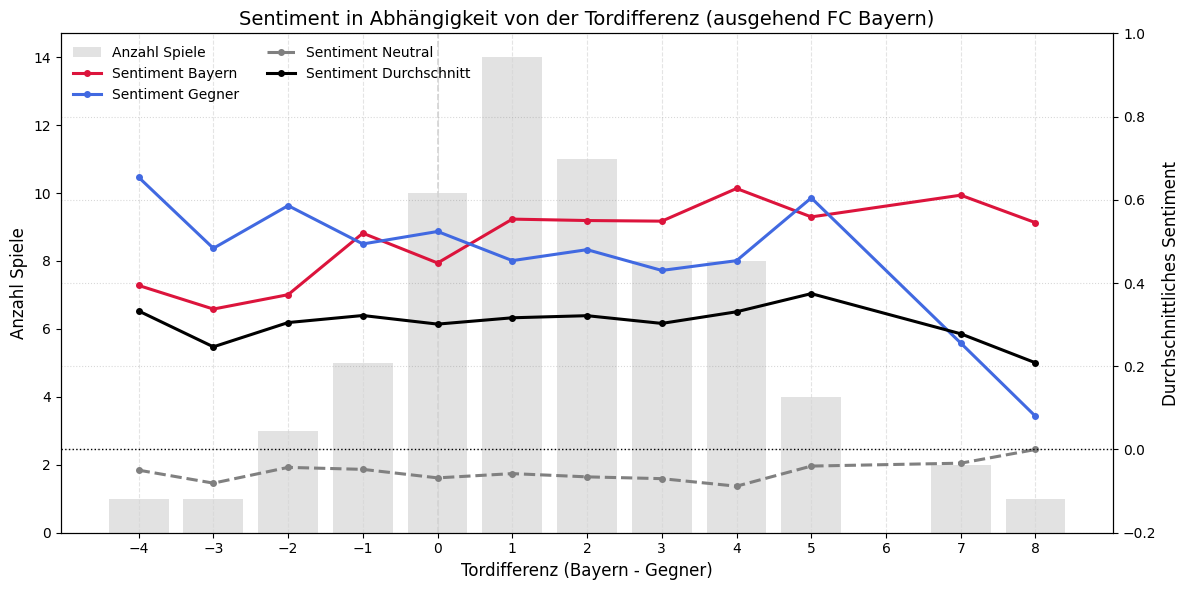

In [ ]:
# --- Datenquelle ---
df_plot = sentiment_tordiff_pivot.copy().sort_values('ergebnis.tordifferenz')
x = df_plot['ergebnis.tordifferenz'].to_numpy()

# --- Linien, die es wirklich gibt ---
line_cols = [c for c in [
    'sentiment.bayern', 'sentiment.gegner', 'sentiment.neutral',
    'sentiment.average'
] if c in df_plot.columns]

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()  # zweite y-Achse für Sentiments

# --- Balken: Anzahl Spiele ---
bars = ax1.bar(
    x,
    df_plot['anzahl.spiele'].to_numpy(),
    width=0.8,
    color='lightgray',
    alpha=0.65,
    label='Anzahl Spiele'
)

# --- Farbpalette ---
palette = {
    'sentiment.bayern':  'crimson',
    'sentiment.gegner':  'royalblue',
    'sentiment.neutral': 'gray',
    'sentiment.average': 'black',
}

# --- Linien: Sentiments ---
line_labels = {
    'sentiment.bayern':  'Sentiment Bayern',
    'sentiment.gegner':  'Sentiment Gegner',
    'sentiment.neutral': 'Sentiment Neutral',
    'sentiment.average': 'Sentiment Durchschnitt',
}

line_handles = []
for col in line_cols:
    h, = ax2.plot(
        x,
        df_plot[col].to_numpy(),
        label=line_labels.get(col, col),
        linewidth=2.2,
        marker='o',
        markersize=4,
        linestyle='--' if col == 'sentiment.neutral' else '-',
        color=palette.get(col, None)
    )
    line_handles.append(h)

# --- Achsenbeschriftungen ---
ax1.set_xlabel('Tordifferenz (Bayern - Gegner)', fontsize=12)
ax1.set_ylabel('Anzahl Spiele', fontsize=12)
ax2.set_ylabel('Durchschnittliches Sentiment', fontsize=12)

# --- x-Achse: Tordifferenzen ---
xmin, xmax = int(np.min(x)), int(np.max(x))
ax1.set_xticks(np.arange(xmin, xmax + 1, 1))

# --- y-Achse (Sentiment): -1 bis 1 ---
ax2.set_ylim(-0.2, 1)
ax2.axhline(0, color='black', linestyle=':', linewidth=1)  # Null-Linie

# --- vertikale Linie bei Unentschieden ---
if xmin <= 0 <= xmax:
    ax1.axvline(0, color='lightgray', linestyle='--', linewidth=1.2)

# --- Grid ---
ax1.grid(axis='x', linestyle='--', color='lightgray', alpha=0.6)
ax2.grid(axis='y', linestyle=':', color='gray', alpha=0.3)

# --- Titel ---
ax1.set_title(
    'Sentiment in Abhängigkeit von der Tordifferenz (ausgehend FC Bayern)',
    fontsize=14,
)

# --- Legende kombinieren ---
handles = [bars] + line_handles
labels = [h.get_label() for h in handles]
ax1.legend(handles, labels, frameon=False, loc='upper left', ncol=2)

plt.tight_layout()


file_prefix = "data/results"
filename = "tordifferenzverlauf"
plt.savefig(f'{file_prefix}/grafiken_png/{filename}.png')
plt.savefig(f'{file_prefix}/grafiken_pdf/{filename}.pdf')

plt.show()

In [ ]:
# 1️⃣ Tordifferenz berechnen
df['ergebnis.tordifferenz'] = df['ergebnis.bayern'] - df['ergebnis.gegner']

# 2️⃣ Kontext dreistufig zuordnen (Bayern / Neutral / Gegner)
def map_kontext(x):
    x = str(x).strip()
    if x == 'FC Bayern München':
        return 'FC Bayern München'
    elif x.lower() == 'neutral':
        return 'Neutral'
    else:
        return 'Gegner'

df['kontext_group'] = df['kontext'].apply(map_kontext)

# Kategorien fixieren, damit Pivot alle Spalten anlegt
df['kontext_group'] = pd.Categorical(
    df['kontext_group'],
    categories=['FC Bayern München', 'Gegner', 'Neutral']
)

# 3️⃣ Ø-Sentiment pro Kommentator & Kontext
kommentator_sent = (
    df.groupby(['offizielle.kommentator', 'kontext_group'], as_index=False)
      .agg(weighted_sentiment=('weighted_sentiment', 'mean'))
)

# 4️⃣ Pivot: Bayern / Gegner / Neutral nebeneinander (Sentiment)
kommentator_pivot = (
    kommentator_sent.pivot(
        index='offizielle.kommentator',
        columns='kontext_group',
        values='weighted_sentiment'
    )
    .reset_index()
)
kommentator_pivot.columns.name = None

# 5️⃣ Anzahl Spiele pro Kommentator
spiele_count = (
    df.groupby('offizielle.kommentator', as_index=False)['source_file']
      .nunique().rename(columns={'source_file': 'anzahl.spiele'})
)

# 6️⃣ Durchschnittliche Tordifferenz pro Kommentator
tordiff_avg = (
    df.groupby('offizielle.kommentator', as_index=False)['ergebnis.tordifferenz']
      .mean().rename(columns={'ergebnis.tordifferenz': 'tordifferenz.average'})
)

# 7️⃣ Sprechanteil pro Kommentator (Counts & Anteile)
sprech_counts = (
    df.groupby(['offizielle.kommentator', 'kontext_group'], as_index=False)
      .size().rename(columns={'size': 'row.count'})
)
sprech_pivot = (
    sprech_counts.pivot(index='offizielle.kommentator', columns='kontext_group', values='row.count')
        .reset_index()
        .rename(columns={
            'FC Bayern München': 'rows.bayern',
            'Gegner': 'rows.gegner',
            'Neutral': 'rows.neutral'
        })
)
for col in ['rows.bayern', 'rows.gegner', 'rows.neutral']:
    if col not in sprech_pivot.columns:
        sprech_pivot[col] = 0
sprech_pivot[['rows.bayern', 'rows.gegner', 'rows.neutral']] = \
    sprech_pivot[['rows.bayern', 'rows.gegner', 'rows.neutral']].fillna(0)

sprech_pivot['rows.total'] = sprech_pivot[['rows.bayern','rows.gegner','rows.neutral']].sum(axis=1)
den = sprech_pivot['rows.total'].replace(0, np.nan)
sprech_pivot['sprechanteil.bayern']  = (sprech_pivot['rows.bayern']  / den).fillna(0)
sprech_pivot['sprechanteil.gegner']  = (sprech_pivot['rows.gegner']  / den).fillna(0)
sprech_pivot['sprechanteil.neutral'] = (sprech_pivot['rows.neutral'] / den).fillna(0)

# 8️⃣ Zusammenführen & Sentiment-Spalten umbenennen
kommentator_pivot = (
    kommentator_pivot
    .merge(spiele_count, on='offizielle.kommentator', how='left')
    .merge(tordiff_avg, on='offizielle.kommentator', how='left')
    .merge(sprech_pivot[['offizielle.kommentator',
                         'sprechanteil.bayern','sprechanteil.gegner','sprechanteil.neutral',
                         'rows.total','rows.bayern','rows.gegner','rows.neutral']],
           on='offizielle.kommentator', how='left')
    .rename(columns={
        'FC Bayern München': 'sentiment.bayern',
        'Gegner': 'sentiment.gegner',
        'Neutral': 'sentiment.neutral'
    })
)

# 9️⃣ Bias-Metriken (tatsächliche Tendenz)
kommentator_pivot['sentiment.bias']    = kommentator_pivot['sentiment.bayern'] - kommentator_pivot['sentiment.gegner']
kommentator_pivot['sprechanteil.bias'] = kommentator_pivot['sprechanteil.bayern'] - kommentator_pivot['sprechanteil.gegner']

# 🔟 Erwartete Parteilichkeit aus Tordifferenz (lineare Regression mit np.polyfit)
valid = kommentator_pivot[['tordifferenz.average', 'sentiment.bias']].dropna()
if len(valid) >= 2 and valid['tordifferenz.average'].nunique() >= 2:
    a, b = np.polyfit(valid['tordifferenz.average'].to_numpy(),
                      valid['sentiment.bias'].to_numpy(), deg=1)
    kommentator_pivot['expected.bias'] = a * kommentator_pivot['tordifferenz.average'] + b
else:
    # Fallback: keine verlässliche Regression möglich -> Erwartung = 0
    kommentator_pivot['expected.bias'] = 0.0

# 1️⃣1️⃣ Ungerechtfertigte Parteilichkeit (Residuum)
kommentator_pivot['unjustified.bias'] = kommentator_pivot['sentiment.bias'] - kommentator_pivot['expected.bias']

# 1️⃣2️⃣ Neuer Parteilichkeits-Score (Gewichte anpassbar)
W_UNJUST, W_SPEECH = 0.6, 0.4
kommentator_pivot['parteilichkeit.score'] = (
    W_UNJUST * kommentator_pivot['unjustified.bias'].fillna(0) +
    W_SPEECH * kommentator_pivot['sprechanteil.bias'].fillna(0)
)

# 1️⃣3️⃣ Gesamt-Average über vorhandene Kontexte
cols_for_avg = [c for c in ['sentiment.bayern', 'sentiment.gegner', 'sentiment.neutral']
                if c in kommentator_pivot.columns]
kommentator_pivot['sentiment.average'] = kommentator_pivot[cols_for_avg].mean(axis=1)

# 1️⃣4️⃣ Ergebnis-View (mind. 3 Spiele)
res = (kommentator_pivot
       .loc[kommentator_pivot['anzahl.spiele'] >= 3]
       .sort_values(['parteilichkeit.score', 'anzahl.spiele'], ascending=[False, False])
       .reset_index(drop=True))

# Ausgabe (wichtige Spalten)
res[['offizielle.kommentator',
     'anzahl.spiele',
     'tordifferenz.average',
     'sentiment.bayern','sentiment.gegner','sentiment.neutral',
     'sprechanteil.bayern','sprechanteil.gegner','sprechanteil.neutral',
     'sentiment.bias','expected.bias','unjustified.bias',
     'parteilichkeit.score']]
res.to_excel("data/results/sentiment_per_commentator_with_justified_bias.xlsx", index=False)

/var/folders/6l/0tgzd1nn0ms4kdqy51q3skzc0000gn/T/ipykernel_92265/1100561919.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['offizielle.kommentator', 'kontext_group'], as_index=False)
/var/folders/6l/0tgzd1nn0ms4kdqy51q3skzc0000gn/T/ipykernel_92265/1100561919.py:56: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['offizielle.kommentator', 'kontext_group'], as_index=False)


/var/folders/6l/0tgzd1nn0ms4kdqy51q3skzc0000gn/T/ipykernel_92265/1723122317.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['source_file', 'kontext_group'], as_index=False)


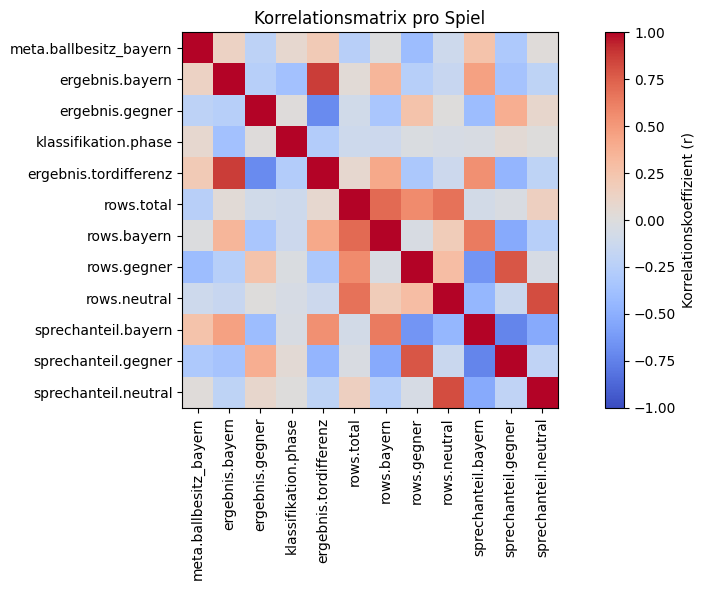

,source_file,meta.gegner,meta.ballbesitz_bayern,ergebnis.bayern,ergebnis.gegner,klassifikation.phase,ergebnis.tordifferenz,rows.total,rows.bayern,rows.gegner,rows.neutral,sprechanteil.bayern,sprechanteil.gegner,sprechanteil.neutral
0,23-24_S10_borussia_dortmund.json,Borussia Dortmund,0.51,4,0,3,4,179,80,54,45,0.45,0.30,0.25
1,23-24_S11_1._fc_heidenheim.json,1. FC Heidenheim,0.72,4,2,3,2,96,47,17,32,0.49,0.18,0.33
2,23-24_S12_1._fc_köln.json,1. FC Köln,0.68,1,0,3,1,85,41,21,23,0.48,0.25,0.27
3,23-24_S13_1._fc_union_berlin.json,1. FC Union Berlin,0.64,1,0,3,1,100,51,22,27,0.51,0.22,0.27
4,23-24_S14_eintracht_frankfurt.json,Eintracht Frankfurt,0.38,1,5,3,-4,111,45,38,28,0.41,0.34,0.25


In [ ]:
# ----------------------------------------------------
# 1️⃣ Kontext dreistufig mappen: Bayern / Neutral / Gegner
# ----------------------------------------------------
def map_kontext(x):
    x = str(x).strip()
    if x == 'FC Bayern München':
        return 'FC Bayern München'
    elif x.lower() == 'neutral':
        return 'Neutral'
    else:
        return 'Gegner'

df['kontext_group'] = df['kontext'].apply(map_kontext)

# (Wichtig) Kategorien fixieren, damit Pivot immer alle Spalten anlegt
df['kontext_group'] = pd.Categorical(
    df['kontext_group'],
    categories=['FC Bayern München', 'Gegner', 'Neutral']
)

# ----------------------------------------------------
# 2️⃣ Basis-Aggregation pro Spiel (per_game) erstellen
# ----------------------------------------------------
per_game = (
    df.groupby('source_file', as_index=False)
      .agg({
          'meta.gegner': 'first',
          'meta.ballbesitz_bayern': 'mean',
          'ergebnis.bayern': 'first',
          'ergebnis.gegner': 'first',
          'klassifikation.phase': 'max'  # z. B. letzte Phase
      })
)
# Tordifferenz
per_game['ergebnis.tordifferenz'] = per_game['ergebnis.bayern'] - per_game['ergebnis.gegner']

# ----------------------------------------------------
# 3️⃣ Zeilen pro Spiel & Kontext zählen
# ----------------------------------------------------
sprech = (
    df.groupby(['source_file', 'kontext_group'], as_index=False)
      .size()
      .rename(columns={'size': 'row.count'})
)

# ----------------------------------------------------
# 4️⃣ Pivot → Bayern / Gegner / Neutral nebeneinander
# ----------------------------------------------------
sprech_pivot = (
    sprech.pivot(index='source_file', columns='kontext_group', values='row.count')
          .reset_index()
          .rename(columns={
              'FC Bayern München': 'rows.bayern',
              'Gegner': 'rows.gegner',
              'Neutral': 'rows.neutral'
          })
)

# Fehlende Kontexte als 0 auffüllen
for col in ['rows.bayern', 'rows.gegner', 'rows.neutral']:
    if col not in sprech_pivot.columns:
        sprech_pivot[col] = 0
sprech_pivot[['rows.bayern', 'rows.gegner', 'rows.neutral']] = \
    sprech_pivot[['rows.bayern', 'rows.gegner', 'rows.neutral']].fillna(0)

# ----------------------------------------------------
# 5️⃣ Sprechanteile berechnen (0–1)
# ----------------------------------------------------
sprech_pivot['rows.total'] = sprech_pivot[['rows.bayern','rows.gegner','rows.neutral']].sum(axis=1)
den = sprech_pivot['rows.total'].replace(0, np.nan)
sprech_pivot['sprechanteil.bayern']  = (sprech_pivot['rows.bayern']  / den).fillna(0)
sprech_pivot['sprechanteil.gegner']  = (sprech_pivot['rows.gegner']  / den).fillna(0)
sprech_pivot['sprechanteil.neutral'] = (sprech_pivot['rows.neutral'] / den).fillna(0)

sprech_pivot[['sprechanteil.bayern','sprechanteil.gegner','sprechanteil.neutral']] = \
    sprech_pivot[['sprechanteil.bayern','sprechanteil.gegner','sprechanteil.neutral']].round(2)

# ----------------------------------------------------
# 6️⃣ Alles zusammenführen
# ----------------------------------------------------
per_game = per_game.merge(
    sprech_pivot[['source_file',
                  'rows.total','rows.bayern','rows.gegner','rows.neutral',
                  'sprechanteil.bayern','sprechanteil.gegner','sprechanteil.neutral']],
    on='source_file', how='left'
)

# ----------------------------------------------------
# 7️⃣ Korrelation berechnen
# ----------------------------------------------------
corr = per_game.select_dtypes(include='number').corr()

plt.figure(figsize=(10, 6))
im = plt.imshow(corr, cmap='coolwarm', interpolation='none', vmin=-1, vmax=1)
plt.colorbar(im, label='Korrelationskoeffizient (r)')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Korrelationsmatrix pro Spiel")
plt.tight_layout()


file_prefix = "data/results"
filename = "korrelationsmatrix"
plt.savefig(f'{file_prefix}/grafiken_png/{filename}.png')
plt.savefig(f'{file_prefix}/grafiken_pdf/{filename}.pdf')

plt.show()

# ----------------------------------------------------
# 8️⃣ Ergebnis prüfen
# ----------------------------------------------------
per_game.head()